# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

from sklearn import tree
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import svm
from collections import Counter

import math

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

# X_competencia = pd.read_csv("X_competencia.csv", index_col="index")
# y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

total_fit_for_evil_for_eval 23
total_not_fit_for_evil_for_eval  27
X_eval
          0       1       2       3       4       5       6   ...       193  \
0  -1.1195  0.6030 -0.7158 -0.3789 -0.1388  0.7073 -0.7359   ...   -1.0288   
3   0.2907  1.0031 -0.5272  0.8402 -1.2717 -1.1037  0.8865   ...    0.8659   
4   1.5610 -1.4369  0.6733  0.3506  1.2520  0.1941  0.5873   ...    0.2312   
5   0.5160 -0.2744  0.6334  0.3783  1.7664  0.3300 -0.8122   ...   -0.6131   
6   0.4907  0.8146  0.8431 -2.1328  0.4632 -0.6371  0.2373   ...   -0.3971   
..     ...     ...     ...     ...     ...     ...     ...   ...       ...   
39  0.6308 -0.3618 -1.7549  1.6194  1.1024  0.4943 -2.7249   ...    0.0174   
41 -0.9380  0.7775 -0.9249 -0.4139 -0.8375 -0.9881  1.2105   ...    1.9503   
42  0.3348  0.4194  0.3144  0.0578  0.3524 -0.7282 -1.1706   ...    0.1454   
43 -0.8160  0.4509  0.6044 -2.2624 -0.4594 -0.0256 -0.4001   ...   -1.0719   
46  0.0158  1.2337 -1.9919  1.1391 -0.6519 -0.8431 -0.7786   ...   

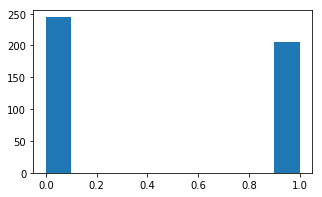

In [3]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO
X_dev, X_eval, y_dev, y_eval = X, X, y, y  # cambiar esta línea si lo consideran necesario

total_minions = len(X.index)
proportion_to_use_for_eval = 0.1
proportion_fit_for_evil = y_dev.sum()/total_minions 

total_to_use_for_eval = int(total_minions * proportion_to_use_for_eval)
total_fit_for_evil_for_eval = math.ceil(total_to_use_for_eval * proportion_fit_for_evil)
total_not_fit_for_evil_for_eval = total_to_use_for_eval - total_fit_for_evil_for_eval

# Mezclar datos por fila (por minion)
X['y'] = y.values
X = X.sample(frac=1).reset_index(drop=True)

print("total_fit_for_evil_for_eval", total_fit_for_evil_for_eval)
print("total_not_fit_for_evil_for_eval ", total_not_fit_for_evil_for_eval)

X_eval = X.loc[X['y'] == 1].head(n = total_fit_for_evil_for_eval)
# X_eval.append( X.loc[X['y'] == 0].head(n = total_not_fit_for_evil_for_eval) )
X_eval = pd.concat( [X_eval, X.loc[X['y'] == 0].head(n = total_not_fit_for_evil_for_eval)] )

X_dev = X[~X.isin(X_eval)].dropna()

y_eval = X_eval['y']
y_dev = X_dev['y']


del X_eval['y']; del X_dev['y']

print("X_eval\n", X_eval)
print("X_dev\n", X_dev)
print("y_eval\n", y_eval)
print("y_dev\n", y_dev)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


# print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
# print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8167,0.6556,0.8177,0.6488
2,0.8250,0.6333,0.8259,0.6250
3,0.8250,0.7111,0.8181,0.7181
4,0.8361,0.7222,0.8286,0.7127
5,0.8083,0.7444,0.8106,0.7444


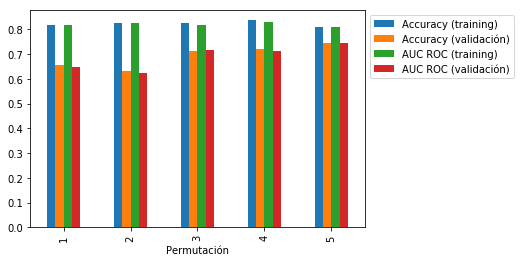

In [4]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
def get_scores(train_indexes, test_indexes, decision_tree_criterion="gini", max_depth=3, metrics=[accuracy_score, roc_auc_score]):
    X_train, X_test = X_dev_np[train_indexes], X_dev_np[test_indexes]
    y_train, y_test = y_dev_np[train_indexes], y_dev_np[test_indexes]

    iteration_classifier = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=decision_tree_criterion)
    iteration_classifier.fit(X_train, y_train)
    
    metrics_scores = []
    
    for metric in metrics:
        y_prediction = iteration_classifier.predict(X_test)
        metrics_scores.append(metric(y_test, y_prediction))
        
        y_prediction = iteration_classifier.predict(X_train)
        metrics_scores.append(metric(y_train, y_prediction))
#     accuracy_test = accuracy_score(y_test, y_prediction)
#     auc_roc_test = roc_auc_score(y_test, y_prediction)

#     y_prediction = iteration_classifier.predict(X_train)
#     accuracy_train = accuracy_score(y_train, y_prediction)
#     auc_roc_train = roc_auc_score(y_train, y_prediction)

    return metrics_scores

## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
# Ejercicio 2.1
classifier = tree.DecisionTreeClassifier(max_depth=3)
classifier = classifier.fit(X_dev_np, y_dev_np)

#classifier.predict_proba([test])

# Ejercicio 2.2


kf = KFold(n_splits=5)
# NO nos olvidemos uqe los indexes son las filas, quizas
for train_index, test_index in kf.split(X_dev_np):
    [accuracy_test, accuracy_train, auc_roc_test, auc_roc_train] = get_scores(train_index, test_index)
    
    accuracies_validation.append(accuracy_test)
    aucs_validation.append(auc_roc_test)
    accuracies_training.append(accuracy_train)
    aucs_training.append(auc_roc_train)
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()


In [ ]:
####################################################################
#Ejercicio extra



def construir_arbol(instancias, etiquetas, altura, criterio):
    #print("Instancias")
    #print(instancias)
    # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario. 
    # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo. 
    ganancia, pregunta = encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterio)
    # Criterio de corte: ¿Hay ganancia?
    if ganancia == 0 or (altura != None and altura == 0):
        #  Si no hay ganancia en separar, o llegue a la altura requerida, corto la recursion. 
        return Hoja(etiquetas)
    else: 
        # Si hay ganancia en partir el conjunto en 2
        instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = partir_segun(pregunta, instancias, etiquetas)
        # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

        altura_rec = None if(altura == None) else altura - 1
        # Paso recursivo (consultar con el computador más cercano)
        sub_arbol_izquierdo = construir_arbol(instancias_cumplen, etiquetas_cumplen, altura_rec, criterio)
        sub_arbol_derecho   = construir_arbol(instancias_no_cumplen, etiquetas_no_cumplen, altura_rec, criterio)
        # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho
        
        # sólo falta conectarlos con un nodo de decisión:
        return Nodo_De_Decision(pregunta, sub_arbol_izquierdo, sub_arbol_derecho)

# Definición de la estructura del árbol. 

class Hoja:
    #  Contiene las cuentas para cada clase (en forma de diccionario)
    #  Por ejemplo, {'Si': 2, 'No': 2}
    def __init__(self, etiquetas):
        self.cuentas = dict(Counter(etiquetas))


class Nodo_De_Decision:
    # Un Nodo de Decisión contiene preguntas y una referencia al sub-árbol izquierdo y al sub-árbol derecho
     
    def __init__(self, pregunta, sub_arbol_izquierdo, sub_arbol_derecho):
        self.pregunta = pregunta
        self.sub_arbol_izquierdo = sub_arbol_izquierdo
        self.sub_arbol_derecho = sub_arbol_derecho    
        
# Definición de la clase "Pregunta"
class Pregunta:
    def __init__(self, atributo, valor):
        self.atributo = atributo
        self.valor = valor
    
    def cumple(self, instancia):
        return instancia[self.atributo] <= self.valor
    
    def __repr__(self):
        return "¿Es el valor para {} igual a {}?".format(self.atributo, self.valor)

#Como hago para refactorizar esto?
def gini(etiquetas):
    diccionario = dict(Counter(etiquetas))
    suma = 0
    for etiqueta in diccionario.keys():
        suma += (diccionario[etiqueta]/len(etiquetas))**2
    impureza = 1 - suma
    return impureza

def ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    etiquetas = np.concatenate((etiquetas_rama_izquierda, etiquetas_rama_derecha))
    n_izq = len(etiquetas_rama_izquierda)
    n_der = len(etiquetas_rama_derecha)
    n = len(etiquetas)
    
    gini_total = gini(etiquetas)
    gini_izq = gini(etiquetas_rama_izquierda)
    gini_der = gini(etiquetas_rama_derecha)
    
    ganancia_gini = gini_total - ((n_izq/n)*gini_izq + (n_der/n)*gini_der)
    
    return ganancia_gini

def entropia(etiquetas):
    diccionario = dict(Counter(etiquetas))
    entropia = 0
    for etiqueta in diccionario.keys():
        proporcion = diccionario[etiqueta]/len(etiquetas)
        entropia += -proporcion*log(proporcion,2)
    return entropia

def ganancia_entropia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    etiquetas = np.concatenate((etiquetas_rama_izquierda, etiquetas_rama_derecha))
    n_izq = len(etiquetas_rama_izquierda)
    n_der = len(etiquetas_rama_derecha)
    n = len(etiquetas)
    
    entropia_total = entropia(etiquetas)
    entropia_izq = entropia(etiquetas_rama_izquierda)
    entropia_der = entropia(etiquetas_rama_derecha)
    
    ganancia_entropia = entropia_total - ((n_izq/n)*entropia_izq + (n_der/n)*entropia_der)
    
    return ganancia_gini

def partir_segun(pregunta, instancias, etiquetas):
    # Esta función debe separar instancias y etiquetas según si cada instancia cumple o no con la pregunta (ver método 'cumple')
    # COMPLETAR (recomendamos utilizar máscaras para este punto)
    instancias_cumplen = pd.DataFrame(columns=instancias.columns)
    instancias_no_cumplen = pd.DataFrame(columns=instancias.columns)
     
    columna_etiqueta = pd.DataFrame(data=etiquetas, index=instancias.index, columns=['etiqueta'])
    instancias_con_etiqueta = pd.concat([instancias, columna_etiqueta], axis=1)
    instancias_cumplen_etiqueta = instancias_con_etiqueta.where(pregunta.cumple(instancias_con_etiqueta)).dropna()
    instancias_no_cumplen_etiqueta = instancias_con_etiqueta.mask(pregunta.cumple(instancias_con_etiqueta)).dropna()
    etiquetas_cumplen = instancias_cumplen_etiqueta.loc[:,'etiqueta'].tolist()
    etiquetas_no_cumplen = instancias_no_cumplen_etiqueta.loc[:,'etiqueta'].tolist()
    
    del instancias_cumplen_etiqueta['etiqueta']
    del instancias_no_cumplen_etiqueta['etiqueta']
    
    instancias_cumplen = instancias_cumplen_etiqueta
    instancias_no_cumplen = instancias_no_cumplen_etiqueta
    
    return instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen

def encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterio):
    max_ganancia = 0
    mejor_pregunta = None
    for columna in instancias.columns:
        for valor in set(instancias[columna]):
            # Probando corte para atributo y valor
            pregunta = Pregunta(columna, valor)
            _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun(pregunta, instancias, etiquetas)
   
            #Ver como refactorizar
            if(criterio == 'gini'):
                ganancia = ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
            else:
                ganancia = ganancia_entropia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
            #print("La ganancia para la pregunta {}, es {}".format(pregunta, ganancia))
            if ganancia > max_ganancia:
                max_ganancia = ganancia
                mejor_pregunta = pregunta
    #print("La mejor pregunta es {}, con una ganancia de {}".format(mejor_pregunta, max_ganancia))        
    return max_ganancia, mejor_pregunta

def imprimir_arbol(arbol, spacing=""):
    if isinstance(arbol, Hoja):
        print (spacing + "Hoja:", arbol.cuentas)
        return

    print (spacing + str(arbol.pregunta))

    print (spacing + '--> True:')
    imprimir_arbol(arbol.sub_arbol_izquierdo, spacing + "  ")

    print (spacing + '--> False:')
    imprimir_arbol(arbol.sub_arbol_derecho, spacing + "  ")


def predecir(arbol, x_t):
    if isinstance(arbol, Hoja):
        return max(arbol.cuentas, key=arbol.cuentas.get)
    
    if(arbol.pregunta.cumple(x_t)):
        return predecir(arbol.sub_arbol_izquierdo, x_t)
    else:
        return predecir(arbol.sub_arbol_derecho, x_t)
        
class MiClasificadorArbol(): 
    def __init__(self, columnas=None):
        self.arbol = None
        self.columnas = columnas
    
    def fit(self, X_train, y_train, max_depth=None, criterion='gini'):
        self.arbol = construir_arbol(pd.DataFrame(X_train, columns=self.columnas), y_train, max_depth, criterion)
        return self
    
    def predict(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t], columns=self.columnas).iloc[0]
            prediction = predecir(self.arbol, x_t_df) 
            print(x_t, "predicción ->", prediction)
            predictions.append(prediction)
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        accuracy = sum(y_i == y_j for (y_i, y_j) in zip(y_pred, y_test)) / len(y_test)
        return accuracy
        
        
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

def get_dt_scores(train_indexes, test_indexes, decision_tree_criterion="gini", max_depth=1, metrics=[accuracy_score, roc_auc_score]):
    X_train, X_test = X_dev_np[train_indexes], X_dev_np[test_indexes]
    y_train, y_test = y_dev_np[train_indexes], y_dev_np[test_indexes]

    iteration_classifier = MiClasificadorArbol()
    iteration_classifier.fit(X_train, y_train, max_depth, decision_tree_criterion)
    
    metrics_scores = []
    
    for metric in metrics:
        y_prediction = iteration_classifier.predict(X_test)
        metrics_scores.append(metric(y_test, y_prediction))
        
        y_prediction = iteration_classifier.predict(X_train)
        metrics_scores.append(metric(y_train, y_prediction))

    return metrics_scores

for train_index, test_index in kf.split(X_dev_np):
    [accuracy_test, accuracy_train, auc_roc_test, auc_roc_train] = get_dt_scores(train_index, test_index)
    
    accuracies_validation.append(accuracy_test)
    aucs_validation.append(auc_roc_test)
    accuracies_training.append(accuracy_train)
    aucs_training.append(auc_roc_train)
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation

display(HTML("<h3> TABLA 1 EJERCICIO EXTRA </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

[-0.8527 -2.4596 -1.5428 -0.4653 -1.6563  0.498   0.1571  1.5687 -0.8337
  0.6074  1.8637 -2.0768  0.501  -1.512   0.0141 -1.9061  1.1494 -0.3022
  0.0341 -1.3189  1.3258 -1.3019 -0.3224  0.848   1.1911  1.3524  1.4799
 -1.4994 -0.5228 -0.4209 -0.3225 -2.3528  0.9093  1.5291 -1.8283 -1.0214
 -1.1663  1.3197  0.2179 -0.6811 -1.7126 -0.3275 -0.5116 -2.2822 -1.4323
 -1.7264 -0.4129  0.4453 -1.1108  2.1097  0.2637 -1.6539  0.2371 -0.4876
 -1.1616 -1.3867 -1.0083  0.2379  0.4134  0.1921  0.9369 -1.4688 -0.449
  1.562   0.5253 -0.2876  0.4199 -0.7562 -0.9634 -1.4808 -1.0621 -0.9626
 -0.7042 -0.7513  0.4685  0.6527 -0.2424  0.7076 -2.0338  0.341   0.759
 -1.1221  1.3413  0.3464 -2.9046 -1.6328  0.982  -0.1513  0.537   3.1278
  1.5376 -1.0985 -0.46   -0.3219  0.1027  0.8128 -1.5549 -0.0397  1.2992
 -1.1537  0.0756  0.7    -1.046  -2.4982  0.9065 -0.5829 -0.3584  0.2628
  0.8431  1.0127  0.1967  0.9736  0.916  -0.4763 -0.3614  0.8725  0.7723
 -0.6488  0.2278  0.8279 -1.7296 -2.12   -1.7552  0.7

[-0.6569 -0.6966 -0.6994  0.8711 -0.1992  0.3536 -0.1787 -0.8113  0.738
 -1.6898  0.0194 -0.1737  0.2282  0.0923 -1.6582 -0.4504  2.1139 -0.3414
  0.9449 -0.0702 -0.1812 -0.6116  0.8469  0.3107  0.6712  1.9792 -0.867
  1.1244  0.5974 -0.3573  0.7243  1.4087 -0.0631 -0.3345  1.0894  0.0649
  0.5162 -0.3659 -1.4337  0.4742 -1.2608 -0.6938 -0.2009  0.3677 -0.7821
  0.554   1.269   0.9992  0.22    0.2824 -0.3434  0.084   1.9679  0.4225
 -0.2951  0.0776 -0.2001  1.0317 -0.6423  0.6037  0.4481 -0.585  -0.4569
  0.6786  1.6117 -0.0279  0.292  -0.5812 -0.1471  2.571   0.4131 -0.306
  2.2595  0.6444 -0.3253  0.8043  1.1967  0.2613 -2.3112 -0.207   2.4711
  0.0293 -0.2289  1.1035 -1.4377 -0.5252  2.2903  2.5352  0.4763 -0.949
 -0.4656 -0.2184 -0.4709  1.5367 -0.8348  1.921   0.352  -0.5675 -0.2112
 -0.196  -0.7189 -0.4347  0.1913 -0.4946  0.1994 -0.1822  1.7859  0.6463
 -1.6782  1.2147  0.5674  1.8615  2.0887 -0.3966 -0.3248 -1.1032  0.1258
 -0.6029 -0.6784 -1.4464  0.2386  0.0616 -0.0319 -1.179

[-0.8332  0.9293 -1.4241 -0.1081 -1.275  -0.3981 -1.5465 -1.1318  0.0908
  0.3809  1.0056  0.9955 -0.3188  1.774   1.1235 -0.727  -0.696   0.8195
  0.4989 -1.1752 -0.5066 -1.8617  0.9691 -0.6485 -0.9223  1.0447  1.8491
 -0.066  -0.1348 -1.4135 -0.2665  0.5287  0.126   1.6086 -1.7353 -0.425
 -0.2848  0.3779  2.3264  1.6024 -0.3031  0.2541 -0.6949 -1.6034 -1.1501
 -0.2355  0.1614 -0.1773  0.0607 -0.8408 -0.0029  1.685   0.1646 -2.4722
  1.9655  1.8112 -1.5455 -0.1412  0.9853  0.0531  0.7215 -0.274   0.1005
  0.2424 -0.1724  0.5343 -0.0845  0.0678 -0.4989 -0.6165 -0.499  -1.2028
 -1.0929 -0.0921  0.6513 -0.874   0.3283 -0.2987  0.3437 -0.9843 -0.2416
 -1.1842  1.3337 -0.8166 -1.9038 -1.0987 -0.3882 -0.1482 -1.0815  1.4452
 -0.8253  0.043  -0.1745  2.3749  0.1675 -0.3701  0.4152  0.1775  0.1302
 -0.5401 -1.303   1.9075 -1.1616 -1.6039  1.6659  1.016   2.1402 -1.1985
 -0.1802  0.072  -0.8216 -0.3083 -0.3336  1.6281  0.1524  1.0126  1.0178
  0.6582  0.8292 -0.0818  0.3431 -1.0662 -0.7485  0.

 -0.2426  1.5372] predicción -> 1.0
[ 8.2691e-01 -6.3594e-01 -6.8181e-01  1.7430e+00  4.3013e-02 -3.2676e-01
  5.8305e-01 -1.1939e+00  1.0955e+00  7.7052e-01  1.5640e+00 -2.1102e-01
 -8.1914e-01  1.1906e+00 -1.0630e+00 -4.1594e-01  2.4897e+00  4.4064e-01
  2.4073e+00 -2.5063e-01  1.2792e+00  1.0529e+00  8.3364e-01  2.5290e-01
 -9.1258e-01 -2.0348e-01  1.1442e+00  1.9889e-01  9.1497e-01  4.2916e-01
 -2.0666e-01  3.0230e-04  1.6009e+00 -7.3737e-01  4.1609e-01 -1.7563e+00
  7.5110e-01 -1.3999e+00 -7.8395e-01  8.0501e-01 -4.8626e-01  1.5073e+00
 -1.2036e+00 -1.3864e+00 -6.7723e-01  4.7179e-01 -3.5280e-01 -6.5020e-01
  1.5647e+00 -2.0646e-01  1.5049e-01 -3.1146e-01 -6.6440e-02  5.9966e-01
  1.9850e+00  7.0676e-01 -4.1317e-01 -6.9984e-01 -4.5031e-02 -1.8133e+00
  2.7816e-01  4.2158e-01  1.1967e+00 -3.1219e-01  2.5017e+00  1.8736e-01
  5.0093e-01  4.3235e-01 -1.1889e+00  1.7983e-01 -1.6416e+00 -1.0893e+00
  8.9005e-02 -1.3325e+00  8.0028e-01 -6.8047e-01 -1.0205e+00  2.0183e+00
  5.1006e-01 -7

[ 1.3203  0.8948 -1.9377 -1.633  -0.1072  1.5093  1.0774 -1.6224 -1.6357
  0.521  -0.4454 -2.5231  0.5341 -0.2253  1.1908 -0.6283 -2.4448  1.6002
 -0.3191 -0.0504 -2.3287 -0.6715  0.6502 -1.9336  0.5572 -1.3942 -0.2031
 -0.7774  0.3939 -2.2058  0.5042  1.0978 -0.7855  0.2669  1.3208 -0.3865
  0.259   0.3831 -0.8344 -1.7456 -0.4253 -1.9261 -1.3846 -0.6859  0.681
  2.1993  1.7536 -0.403   1.8644 -2.0834 -0.1165 -0.0246 -0.5963  0.3301
 -2.1582  0.8286 -0.6482  0.5514  1.3896 -0.3887  0.5094 -0.8193 -0.7375
  1.8531 -2.2072  0.8818  0.3656 -0.1633 -0.3184  0.6054  0.0775 -0.358
  0.5553  0.9677  0.1919 -0.2986  0.3997 -0.0645  0.7674  0.0932 -2.0534
 -0.4471 -0.0521  1.3858 -0.5778 -0.3925 -1.8456 -0.8181  2.8298  0.1055
  2.5612  1.16   -1.7391 -1.8241 -0.5793 -2.4871 -0.2755 -0.2367  1.303
  0.5453  0.5302  1.5551 -0.157  -0.6235  0.3081 -1.9329  0.848  -0.0457
 -0.3929 -0.0688 -1.6146 -2.4551 -2.4998 -1.7374 -0.4806  0.5312 -0.2485
 -0.1621  0.8517 -0.4924  0.2299 -0.6708  0.3684 -0.80

[ 4.0464e-01  5.4268e-01 -2.0277e+00 -3.9320e-02 -1.9640e+00 -1.2302e+00
  8.1508e-01 -1.7522e-01  3.5152e-01  9.2711e-01 -6.6531e-01 -9.7278e-01
  4.4161e-02 -1.3548e+00  1.5061e-02 -1.0381e+00 -2.3566e-01  2.0891e-01
  1.0011e+00 -1.7325e+00  1.6631e-01 -4.1977e-01  6.8098e-01 -1.1413e+00
 -6.8739e-01 -1.5022e+00 -1.7243e+00 -2.1059e+00  4.4357e-03  8.6237e-02
 -5.4985e-01  2.3319e-01 -5.9115e-01 -1.3059e+00 -2.8108e-01  2.4098e+00
 -1.3240e+00  6.4333e-01 -3.1511e-01 -3.3698e-01 -7.6149e-01  1.1546e+00
 -5.4593e-01 -1.5907e+00 -2.2331e+00  2.6713e-01 -2.7613e+00  9.8347e-01
 -4.7163e-01 -2.8215e-01 -1.0778e-01  1.5796e+00 -2.5318e+00  2.1985e+00
  5.8913e-01  4.1071e-01 -2.1635e+00  8.1541e-02  1.6813e+00  5.1707e-01
 -1.7255e+00  7.6582e-01 -3.5369e-01  1.0342e+00  2.1970e-01  2.8054e-01
 -1.9411e+00  7.0656e-01 -1.8470e+00  1.9794e-01 -2.2956e+00 -1.5655e+00
 -1.0823e+00 -3.7232e-01 -1.3672e+00  4.2009e-01  1.0156e+00  2.4132e+00
  1.0808e+00  3.2259e-01 -2.0656e-01 -2.8489e+00  2

[ 8.8718e-01 -3.6009e-03 -2.1423e-01 -5.3182e-01 -5.1612e-01 -5.6280e-01
 -1.0187e-01 -8.8835e-01  6.8878e-01 -5.5780e-01 -8.8757e-01 -1.0903e+00
 -9.8943e-02  7.6410e-01 -3.3982e-01 -5.8444e-01 -2.4415e+00  5.3137e-01
  5.6793e-02 -4.6777e-02 -4.2268e-01 -6.8726e-01  1.3575e-01 -1.0465e+00
  1.9558e-01  1.0946e+00  1.8335e+00 -1.0403e+00 -7.5927e-02  1.4481e-01
  5.7944e-01  3.1189e-01 -5.1510e-01 -5.8353e-01 -1.4768e+00 -5.9712e-02
  2.0290e+00  1.0017e+00  8.3013e-01 -1.0274e-01 -3.9116e-01  1.4650e+00
  1.1761e+00  2.2716e-01 -2.4347e-01  1.4959e+00 -1.8846e+00 -1.7561e+00
  1.7257e+00  4.8379e-01  1.0997e+00  7.0979e-01 -7.4083e-01  9.9054e-01
 -1.7316e+00  9.9627e-02  6.8507e-01 -7.6517e-01 -6.8385e-01  1.0322e-01
  8.1677e-01 -8.8635e-01 -3.4827e-01 -2.6214e-01 -2.5026e+00 -5.5023e-01
 -3.5994e-01 -8.3158e-01  1.0493e+00 -3.5334e-01 -5.2289e-01  4.6631e-01
 -1.3305e+00 -1.5273e+00 -4.9663e-01 -1.6206e+00 -4.6303e-01 -9.6549e-02
  7.4403e-01  1.7133e-01 -2.8038e+00  7.5485e-01  5

[-1.2376  0.7937 -0.6266 -0.6557 -0.9653 -1.2441 -1.3559  0.2243  1.3998
  0.3335 -1.2652  0.6199 -0.2861  0.4258  1.6341  0.0048  1.4993  1.1982
 -1.2731 -1.5575  1.4159 -2.0386  0.5544 -2.6449 -0.4821 -0.9371  0.2313
 -0.6435 -0.8422 -0.3861  0.6598 -0.397  -0.0441  1.9966 -0.6123  1.0402
 -0.9733  1.6258  0.76   -0.9348 -2.6947  0.0682  0.2052 -0.0596 -1.3098
 -0.9256 -1.0801 -0.4988 -0.0629 -0.4812 -0.1816  1.6659  0.625  -0.4397
  0.1895 -0.0089 -1.7115  0.5428 -1.1398 -2.0816 -0.5044  1.4846 -1.0863
  0.8352  1.6414  1.5206 -0.0602  0.8644 -1.874  -1.9802 -1.1641 -1.5658
  1.5633 -0.1876 -0.9314  0.1807  0.7806  0.378   1.3475  0.9567  2.3293
  0.2112  1.6373  1.4667 -1.6655 -0.6578  1.3546 -0.2203  1.6039  1.2596
  0.4728  0.1021  0.317   0.6706 -0.5415  1.8321 -1.6713  1.2102  0.4734
  0.3645  0.2749  1.5998 -1.8715 -1.0221 -1.3199 -0.7758 -0.4448 -0.4295
 -0.5061 -1.1784  1.5863  1.2031  2.1357  0.7198  0.1214 -0.8994 -0.6122
  0.8993 -0.8989  0.7026  0.945  -0.8894 -0.7007  0

[-0.9469 -0.7338 -0.2524 -0.8053  0.1147  0.6238  1.2036  1.5697  0.3955
 -0.2396 -0.5544  0.837  -0.9433 -1.8002 -0.1308  0.159   2.1735  0.5694
 -1.6429  0.3157 -0.45   -1.6332  1.146   0.092   1.0131 -1.043  -0.6576
  0.6168 -0.7635 -0.1873 -1.2292  0.8239  1.3295  0.1219 -0.8797  0.184
  0.5689  0.2444 -0.0339 -0.209   0.0531  0.6116 -0.9076 -1.037  -0.9476
  0.3149 -1.2606 -0.3724 -0.04    0.235  -0.9938  1.3693  0.8201 -0.7116
  0.9763  1.5756 -0.2298 -0.3898  0.6155  0.3478  0.5858  0.12   -1.2556
 -2.357   2.1612  2.0313 -0.4421 -0.0917 -0.2925 -0.2676 -0.3849 -0.2473
  0.3181 -0.8157 -1.6557  1.1522 -0.6928 -2.1306 -0.9781 -0.3851  1.9872
  0.8444  0.0291  0.4797 -1.4085  0.7388  2.389  -1.3208 -0.9458  0.5324
 -0.0722 -1.2781  0.5502  0.2947 -1.4371  2.0457  0.5921 -2.2614  0.5285
 -1.2201 -1.1995 -2.0544  0.3405 -0.8839  0.2249  1.0011 -1.3256 -2.246
 -1.4672  0.4375 -0.0426  2.0811  2.1901 -0.5851 -0.3663 -1.0493  0.6271
  1.0748  2.3715 -0.3615  1.5284 -0.0195  0.7008 -0.7

[-0.5931  0.5493  1.7316  0.8789  0.6529  0.4516  0.8349 -0.1247  0.3832
 -0.8805  0.2135  0.4248 -0.5648  0.5392  0.5556  0.0392 -0.9517 -0.3386
 -0.0442  1.0549 -0.1164  1.1027  1.0947 -1.3517 -1.2191  0.0469 -0.5907
  0.3981  0.8557  0.798  -0.2735 -0.7614 -0.6793 -0.4134  0.2608  0.7799
  0.7017  1.1209 -0.637  -0.1806 -0.1285 -0.4357  0.2823  0.4078  1.584
  1.0122 -1.0537  0.2751  0.7752  0.6111 -1.0224 -0.7809 -0.5131 -1.0786
 -0.5839 -0.3517  0.068   0.746   0.0105  1.217   0.7334 -1.8838  0.9287
 -0.892  -1.3468 -0.6031  0.659  -0.8897  0.4816  1.0998  0.3441  0.9409
  0.2758  0.9907 -0.2604 -0.2162  1.7133 -0.0112 -0.2768  1.3078 -0.9286
  0.5016 -0.8725  0.1219  1.6867  1.5669 -1.0584 -0.4642 -0.0953 -0.4789
 -0.3098  2.0067 -0.198   1.0019 -0.7147 -1.0151  1.7992 -1.2065 -0.4821
  0.4778 -1.979  -0.2314  1.1674 -0.1918 -2.1317 -0.4387  0.5109 -0.6278
 -0.0561 -1.3975  0.5362 -1.1077 -0.6192 -0.4002  0.3461 -1.5366  1.6702
 -1.8339 -0.2917 -0.1694  0.3263  0.052   0.1638 -1.

[ 1.1679e+00  5.2370e-01 -7.6730e-01 -1.2634e-01 -1.9542e+00  7.0699e-01
 -3.5964e-01  1.9840e+00 -1.5472e+00  1.5901e+00  1.3419e-01  4.1512e-01
  5.5072e-01  1.1598e+00  4.2028e-01 -6.6630e-01 -3.7405e-03 -8.7518e-01
 -3.2738e-01 -1.1086e+00 -3.4725e-01  7.8842e-01  1.5050e+00 -1.2793e-01
 -9.5638e-01  1.4533e+00  3.2575e-01 -1.1819e+00 -1.0063e+00 -6.1002e-01
 -1.4745e+00  1.6651e+00  6.3435e-02  6.5236e-01 -3.2270e-01 -1.3855e-01
 -1.5702e-01 -6.9418e-01 -1.3740e-01 -4.8984e-01 -1.8132e+00  3.3453e-01
 -1.3228e+00 -5.1848e-01 -1.5036e+00  3.6907e-01  8.0404e-01  1.8059e+00
 -1.0094e+00 -1.2374e+00 -1.0409e+00  5.7386e-01 -1.3158e+00  2.5265e-02
 -1.4259e+00 -2.0216e+00 -2.2962e+00  1.1169e+00 -9.8218e-01  1.4159e-01
  5.2342e-02 -9.6363e-01 -1.0384e+00  1.4061e+00 -4.3759e-01 -2.6052e+00
 -6.2518e-01  1.7838e+00 -2.0403e+00 -6.7888e-01 -1.1105e+00 -1.6378e+00
  2.0633e+00  4.2507e-01  1.6536e-01 -2.7069e-01  4.5653e-01  2.7494e-01
  1.0137e+00 -3.7025e-01 -9.5411e-01 -7.4389e-01  2

[ 0.6302  0.5426 -1.1405 -0.476   0.0398 -0.5574 -1.0636 -0.9622  1.1648
 -1.3494 -1.0968 -0.0387 -1.4392 -0.5781 -0.6388 -1.6607 -2.1857  1.7998
  0.1155 -1.4373 -0.6376  0.5801 -0.3917 -0.7789  0.2547  0.6524  0.5459
 -0.2264  0.8765  1.1263  0.449  -0.1258  0.1827 -0.7059 -0.8797 -0.5943
 -1.9956  1.3977  0.9533  0.878  -0.1534  0.3131 -0.382  -0.7329 -0.2062
 -0.8959  0.2218 -0.1515 -0.53   -1.6957 -2.2948 -1.3365 -0.1626  1.2602
 -0.1653 -0.5286 -0.9385 -0.398   2.049  -0.1386 -0.0048 -1.667  -0.1139
  1.4509 -2.8612  0.7126  1.0516  1.2    -1.3077  0.5278 -0.9206 -1.0535
  0.4266 -0.8385  1.2736 -0.7865 -0.6738  0.2356 -1.3655  0.6779 -3.0484
  0.0087 -0.1226 -1.1023 -0.7038  0.0763 -2.4503  1.9071  0.4628  0.4383
  1.9605 -1.2415 -0.1525 -0.6977 -0.4336 -2.5552 -1.4851  3.3081  0.3597
 -1.4456 -0.5859 -1.0548 -0.6448 -0.4166 -0.3584  0.9508  0.9082 -0.4779
 -0.9837 -1.909  -1.7033 -2.2674 -2.7465  0.1057  0.1212 -0.7722 -1.3202
 -1.2897  0.7009  0.2577 -0.1734 -0.2797 -0.9796 -0

  0.1573 -1.177 ] predicción -> 1.0
[ 0.8332 -1.3124 -0.4362  0.8952 -0.1713 -1.0224 -1.1986 -0.39    0.7487
 -1.1075 -1.5942 -0.5989  1.2169  1.7556  0.4675 -1.2518  0.8964  0.4027
  0.4548 -1.3145 -0.9676  0.4212  0.0169 -0.3806  1.5681 -0.7053 -0.8495
 -1.0004  0.0746  0.6738 -0.7165 -0.5796 -1.0246  0.2231 -2.6611 -0.4846
  0.7744  0.437  -1.6917  0.1182  0.6359  2.4103 -1.5953  0.1464 -1.6686
  0.9702  0.7388  0.2189  0.7953 -0.8929  0.8867  0.262   2.2008 -1.2099
  0.0263  0.2443 -1.4516 -2.1763  1.5517 -1.6902 -0.2279  0.6251  0.9237
 -1.4986  0.423   0.0153 -0.5036  0.7274 -0.4514 -1.4653 -0.6245 -0.841
  0.1637  0.2795 -0.7656 -0.6585  0.563   0.6052 -1.2317 -0.9465  0.7999
 -1.1819 -0.7596 -1.4159 -0.2923 -1.4866  0.4411  1.4024  0.232   1.148
  0.2367 -1.0707  0.4675 -1.1544  2.985   0.8489 -0.9537  1.7206  0.2678
  0.5694  0.8358 -1.0031 -1.0594 -0.892  -0.9033  1.9362  1.2268 -0.9398
 -0.299  -0.121   1.3848  0.4991  0.3848 -0.5842 -0.232  -0.7197 -0.7509
 -1.0963 -0.4639 

[-0.0467  0.7315  0.4067  0.5575  1.1518 -0.7761  0.4583 -0.442  -0.0414
  0.2866  0.3315  0.239  -1.1237 -0.1207  0.146   0.8297  1.0628 -1.8687
 -0.896   0.8946 -0.3344  1.0249  1.0342 -0.5622  0.6288  1.1946 -0.3156
  0.401  -0.9434  0.8129  1.3716  0.202  -2.1991  0.7993  0.532   0.3454
  0.4744 -0.5469  0.6617 -1.1635  1.0904  0.9288  0.6996  1.2755  0.0722
  0.0846 -1.222   1.9934 -0.4163  0.1385 -0.8061 -0.408   0.8007 -0.8894
  1.0206  2.37    0.832   1.5144 -0.0913  0.0583 -0.638  -1.5328  0.9371
 -1.1073  1.1875 -0.2327  1.5081 -0.7891  0.3577 -1.216   1.7909  1.7267
  1.0195  1.0441  1.5934 -1.084  -1.0997  0.3148  0.1513 -0.1808  1.2647
  0.6697  0.1196  1.225   1.2147  0.6142  1.1938  1.3424 -0.6068  0.9778
 -2.0458 -0.1873  0.4008  0.6027 -0.2278  1.6255  0.9356  0.0279 -0.7145
 -0.1588 -0.7025  1.6909  0.8485  1.2456  0.4455 -0.8343 -0.7803  0.0527
  1.3937 -0.6203  1.7637  0.9572  0.9264  1.0759  1.3935  0.9796 -0.2006
  0.2945  0.6151 -0.1869  0.4951  1.0407  0.52    0

[ 1.7082e+00 -5.0773e-01 -2.0420e+00  2.9157e-01 -1.9415e+00  3.6848e-01
 -2.1227e+00 -1.1522e+00 -8.2018e-01  6.8656e-01 -1.6688e+00 -1.8711e-01
  7.8745e-01  1.9397e+00  8.5943e-01 -2.5465e+00  1.1711e-01  2.0675e-01
  8.3739e-01 -2.0178e+00  9.7320e-01  1.0360e+00  1.1379e-01  9.0461e-01
 -3.4129e-01  4.6134e-02 -8.2365e-01 -1.0940e+00  1.5170e+00 -7.2663e-01
 -1.0253e-01 -1.0199e+00  3.7792e-01 -1.4639e-01  1.0155e+00 -4.3457e-01
  5.2136e-01 -2.2509e-01 -8.9789e-01 -1.2276e+00 -1.7078e+00  2.9325e-03
  5.6709e-01 -2.4139e+00 -9.6987e-01  7.2640e-01  1.0135e+00  1.2123e+00
  2.7897e-01  1.6387e+00 -1.7670e+00  8.0802e-01  4.3853e-01 -1.7967e+00
 -1.9378e+00  3.9304e-01 -2.7856e+00 -7.3116e-01  1.5949e+00  7.5517e-01
  2.2825e+00 -1.6255e+00 -1.0479e+00  1.1390e-01  5.6474e-01  1.6421e+00
 -1.3590e-01  1.0601e+00 -8.9980e-01  3.0622e-01 -1.7403e+00 -2.7350e+00
  5.4205e-01 -6.6625e-01 -6.6811e-01 -1.0275e+00 -1.3274e+00  7.4661e-01
  5.9896e-01 -2.7515e-04  2.9561e-01 -2.2518e+00 -5

[ 1.4914  0.1644  1.2315  1.2429  1.5576  0.0455  0.1302 -0.4344  1.6087
 -0.2758  0.3386  1.5445  0.5565  0.2837  0.4684  1.2074 -0.901  -0.8234
  0.8073  1.2103  0.7609 -1.2941  0.4743 -0.7564  1.1502  0.9275  1.2673
  0.7673  0.1795 -0.444  -1.7277  1.0693 -0.2121 -0.6889  0.4129  1.0311
  0.4563 -1.9779  1.7549  0.7123  0.8538 -0.7352 -0.4034  0.4312  0.4583
  0.3217 -1.5063  0.3143  1.0127 -0.6999 -0.2397  1.1622 -0.5786  1.661
 -1.8769  0.7482  1.4358  1.806   0.2836 -1.2539  0.5738  0.1995 -2.1231
 -1.862  -0.9519  0.5012 -1.3709  1.7437  0.8669 -0.6378 -0.0788  0.8707
 -0.5521 -0.3909  1.9594 -2.4267 -1.0197 -2.025   0.181  -0.9358 -0.9063
  0.7524 -0.354  -0.335   2.4827  1.3734 -1.6601  0.2538 -0.4289 -0.3792
  0.283   1.4907 -1.6054  1.2659 -1.2125 -0.8588  1.1911 -1.1    -1.4287
  0.0028  1.1758 -0.5307  0.4592 -0.4821  2.2059  0.0341 -0.4277  0.3328
 -0.2702 -0.0246  2.2381 -0.8614 -0.8908  0.1207 -0.8375 -0.3148  0.4997
  1.3773 -0.5639  2.5983 -1.0388  0.7481  0.9032 -0.

[ 1.7506e+00  5.3370e-01 -5.3712e-01  1.7982e+00 -2.7688e-01 -1.4765e+00
 -6.5022e-01 -3.1036e-01 -4.3172e-01  8.9881e-01 -4.5897e-01  2.3326e-01
 -2.5958e-02 -1.3485e-01  3.6865e-01  8.5556e-01 -1.6449e+00 -7.8863e-01
 -1.5644e+00  6.2092e-01 -4.5350e-01  1.1555e+00 -1.2373e+00 -1.0120e+00
 -1.6166e-02  1.1847e+00  2.1699e+00 -3.7931e-01  1.8895e-01  5.7053e-01
 -8.2282e-02 -1.3627e+00  3.9309e-01  1.2657e+00  6.9398e-01 -3.1050e-01
 -8.8076e-01 -1.0843e+00 -5.5251e-01 -1.2173e+00 -2.5746e-01  9.0856e-01
  4.2164e-01  4.3601e-01  1.4940e+00  1.2790e+00 -1.1382e-01 -5.1140e-01
 -1.1436e+00 -7.8995e-01 -2.3953e+00 -1.2094e+00  1.8754e+00 -1.0626e+00
 -4.5829e-01  9.4892e-03 -5.6322e-01  1.3531e-01  9.1106e-01  1.3719e-01
 -4.0558e-01  8.4595e-01 -8.4246e-01  1.1654e+00 -1.6191e+00  5.4372e-01
 -1.0838e+00 -7.1681e-01 -7.3470e-01  8.5725e-01  7.5809e-01  1.5509e-01
  8.2745e-01 -4.0597e-01 -3.4699e-01 -6.6897e-02 -1.2190e+00 -5.3578e-01
 -2.0091e-01 -1.2987e-01 -1.5174e+00 -1.2394e+00 -4

 -1.4899 -1.2254] predicción -> 1.0
[ 1.3171e+00 -1.3315e-01 -6.7489e-01  9.3306e-01 -5.1173e-01 -3.7010e-02
  1.0810e+00 -2.8698e-01 -2.2475e-01  1.0812e+00 -1.4019e+00  1.0330e+00
  5.6254e-01 -3.7171e-01  1.7691e+00 -1.4133e+00 -1.5570e+00 -3.1091e-01
  9.1241e-01 -1.3722e+00 -1.3583e+00  1.0946e+00 -2.6587e-01 -4.3520e-01
  1.1411e+00  5.0058e-01 -1.6285e+00 -5.1534e-02  7.0793e-01 -6.5251e-01
 -8.5572e-01 -5.3338e-01  3.9050e-01  2.0801e-01 -3.9119e-01  8.7522e-01
 -1.2058e+00  4.9399e-01  1.8797e+00  6.6076e-01 -1.6520e+00  1.1767e+00
  7.2641e-01 -7.4952e-01 -1.1357e+00 -5.0951e-01 -1.1457e+00 -1.1237e+00
 -1.0209e+00 -3.3802e-03  1.3771e+00  4.3371e-02  5.6150e-01  2.0827e-01
  3.6045e-01  6.8914e-02  1.8392e-02  1.2575e+00  2.2107e-01 -2.5357e-01
  4.4332e-01  5.2750e-01 -1.3891e+00 -1.2190e+00 -1.4361e+00 -3.5037e-01
 -1.4844e+00  5.0921e-01 -1.1228e-01 -5.3769e-01  5.7867e-01 -7.9765e-02
  1.5226e+00  6.8576e-01  4.0997e-01  5.0839e-01 -2.2288e+00  1.1987e+00
 -3.9427e-01  5

[-0.8504 -2.0833 -1.7904 -1.1661 -0.2653  2.5092  1.3911  0.4073 -0.3179
 -0.7519  2.4406  0.6274  1.5274 -1.7005  0.7489 -0.6339  1.5674  3.0689
  0.3577 -0.205   0.5778 -0.2854  0.4696  1.0536 -0.7035 -0.4143  0.3592
 -1.1112 -0.1809  0.0189  1.153   0.169  -0.4423  0.083   0.3912 -0.8033
 -0.8116 -0.4195  0.4986 -0.4957 -0.6538  0.6013 -2.0852 -0.8248 -1.0782
 -1.6927 -1.4938 -1.2413  0.0837 -0.0637  0.7289  0.1243  1.9768  0.1488
  0.7417  0.137  -1.3997  0.6187  0.9532  1.7245  0.8452  1.6386  0.1817
 -0.4987  1.4314  1.2484  1.1266 -1.424  -1.0749 -0.5701 -0.8144 -0.262
 -0.0603  2.1955 -1.4804  1.1085  0.1679 -0.2722  0.0586  0.498   1.655
  0.1335 -0.8242  0.6422  0.5146 -1.8808  1.2276  0.0952  0.0945 -0.9395
 -0.2505  0.8003 -0.3829 -0.0608 -1.1658  1.8067 -1.2516  0.275  -0.5689
  1.4139  0.4906  0.1264 -0.5881  0.369   0.0712  1.37    0.5114  0.7632
  2.8553  0.0389  1.3368  1.4327  1.4012 -0.2132  0.2946  1.0728 -0.5956
  1.3804 -0.5846 -1.3549  1.2634  1.0038 -0.3683  0.0

  0.348  -1.3146] predicción -> 1.0
[ 0.0396  0.517  -0.8266 -1.1071  0.0869  1.7763 -1.9052  0.9471  1.7619
 -0.1983  0.2723  1.151   0.8217  0.2988  1.4698 -0.9962 -0.2443 -1.0039
  0.3413 -0.1369  0.1071 -1.3018 -0.2907 -0.2557  0.1697 -1.3602 -2.0169
 -0.2782 -0.1262 -0.7071 -0.1477  0.2234 -0.7783 -0.5187  1.2598 -0.3129
  0.5416 -0.5782 -0.7675 -0.8986  0.034   0.3011  0.0993 -1.061  -1.2582
  0.7747  1.1384 -0.0338  0.5943  0.4579  0.08    0.1947  0.9597  0.4881
 -0.7302  0.6659 -1.599  -0.8136 -1.2888  0.6862 -0.8644  1.9663  0.0914
 -1.8378  0.0487 -0.0975 -0.5849  0.1317 -0.1404 -1.2639 -2.1494 -2.1993
  1.8732 -1.3285 -0.1801 -0.0428  0.3508 -1.8855  0.5946 -0.9831 -0.2503
 -0.3593 -1.9736 -0.0919 -1.3859 -0.859  -0.3835  0.3969  1.2311  3.1532
  0.4092  0.0779 -0.0568 -0.857  -1.3403 -0.6196 -1.4636  0.2912 -0.0095
  1.6344 -0.4016 -1.7184 -0.7281 -0.7858 -0.3312  0.9872 -0.5183  0.5984
 -0.1201  1.4548 -0.4312 -0.5674 -0.3326 -0.2547  1.677   0.9641  0.6055
  0.1794  0.789

[ 1.0873  1.4453 -0.119   0.2528 -0.3564  0.7769 -0.544  -0.8446 -1.9813
 -1.1083 -0.8992  0.8341 -1.3151 -0.0948 -0.6655 -0.3124  0.4266 -1.3338
  0.7785 -0.0426  0.6645 -0.8947  0.3973  0.5678  1.636   0.044  -1.3272
 -0.4663  1.7354  0.9826  1.0338  1.7818  0.342  -0.3875  0.2675  1.0211
  1.0349  0.5247  0.3474  0.2308 -0.4135  2.466  -0.5316  0.0095  0.5247
  1.1446 -0.2752  1.8446 -0.2038  0.7396 -1.303  -1.346   0.2163  1.3688
 -0.672   0.4996  0.2466  0.1577 -0.1462 -0.4171 -1.5919  1.274   0.8154
  0.7467  0.3712  0.2804  0.3213 -0.2748 -0.0656 -1.7716 -0.9809 -0.0904
  0.2085 -0.7826  0.0781 -1.2693 -0.6673  1.0688  1.0339  1.3469  0.4405
  0.6791  0.303  -0.2074 -1.5953 -0.0516  0.5159 -0.6144 -1.5255  0.9995
 -0.1582  0.5579  1.3396 -0.2399  2.3013  0.6044  0.2149  0.2235 -0.895
 -0.0357 -0.7793 -1.4567 -0.2741 -0.4427  0.469  -0.3267  1.5482 -0.0364
  0.4666 -1.4413  2.2784  0.2563  0.5587 -0.1322  0.4677  0.6728 -1.5836
 -0.54    0.0118  0.1275 -0.548  -0.3071  0.0341 -0.

[ 2.3379e+00  1.8002e+00  1.0891e-01 -8.6381e-01 -1.0315e+00 -1.6083e+00
 -1.6421e+00  1.1284e+00 -3.0440e-01  1.6375e+00  7.2639e-01 -4.7249e-01
  1.8322e+00  1.6683e+00  1.1059e+00  4.5967e-01 -1.0575e-04  1.6427e+00
 -1.9074e+00 -1.5830e+00  7.6494e-01  1.1083e+00 -9.7084e-01 -2.5163e-01
  3.5289e-01 -6.2656e-01  1.0729e+00  2.4378e-03  4.6705e-01 -1.1659e+00
  8.3390e-02  1.6769e+00 -4.9024e-01 -3.5488e-01 -5.2113e-02 -1.1610e+00
 -1.0809e+00 -4.1887e-01  1.6718e-01 -1.6980e+00  5.5735e-01  7.4028e-01
  6.0164e-02  2.4267e-01  3.9693e-01 -5.7382e-01 -2.8282e-03  1.5766e+00
 -4.1217e-01 -1.2072e-01  8.9505e-01 -4.1472e-01 -2.1104e+00  2.4273e-01
  2.2427e+00  6.2589e-01 -2.2177e-01 -2.1618e+00  1.1615e+00  1.3300e+00
  2.4760e+00 -7.7829e-01 -3.2276e+00 -4.2291e-01 -4.3623e-02  1.7913e+00
 -8.9613e-02 -3.2389e-01 -1.0751e+00 -1.5461e+00 -3.3024e-01 -3.0012e-01
  1.0263e+00 -1.9918e+00 -2.7561e-01  5.0464e-01  1.0271e+00  5.2310e-01
  4.7636e-01 -7.1097e-01  3.9104e-01 -1.0534e+00  1

 -1.8752e+00 -8.6645e-03] predicción -> 0.0
[-1.8858e+00 -4.1772e-01 -1.7186e-01 -1.4990e-01 -6.8166e-01 -2.0577e+00
 -1.9781e-01 -9.1316e-01  6.4811e-01 -2.4651e-01 -3.9774e-01 -5.6994e-01
 -8.2903e-01  1.0986e+00 -1.9258e-01  1.4826e+00 -4.3777e-01  1.8711e-01
  8.3835e-01 -6.9330e-01  1.7845e-01 -3.4160e-01 -1.6544e+00 -6.4236e-01
  2.1631e-03 -5.9696e-01  8.2810e-01 -8.3819e-01 -7.3608e-01 -8.2871e-01
  5.2846e-01 -1.6706e+00  3.8193e-01  3.9663e+00  1.0030e-01  1.8552e+00
  6.3725e-01 -3.9316e-01  1.0238e+00 -4.3418e-01  8.7428e-01 -8.3336e-02
  4.3041e-01  6.1816e-01 -8.8926e-02 -5.3000e-01 -1.3503e-01 -1.4521e+00
 -2.7625e+00  1.5252e+00 -5.2417e-01  6.3216e-01  4.2494e-02  3.6252e-01
  6.6088e-01 -5.0352e-01 -6.2577e-01  1.9406e-01 -8.3495e-01 -1.7869e+00
 -1.0274e+00 -7.7112e-01  1.0323e-01  1.3592e+00 -5.9406e-01 -7.1220e-02
  7.7853e-01  3.7650e-01  9.6312e-01 -6.7140e-02 -7.7908e-01  1.0221e-01
  3.7540e-02  1.6959e+00 -1.3851e-01  1.0044e+00  2.9312e-02 -3.2336e-01
  4.411

  7.4483e-01 -4.5547e-01] predicción -> 1.0
[ 1.2222e-01  1.5039e-01  2.5836e-01 -1.4830e-01 -2.7826e-01 -7.6834e-01
  1.9943e-01  1.8363e+00 -1.1910e+00  3.4743e-01 -2.0370e+00 -5.7064e-01
  5.5155e-01  1.2562e+00 -7.1685e-01  5.9241e-01  1.2685e+00  5.2014e-01
  1.1720e+00 -7.2336e-01  6.7581e-01  6.0456e-01 -5.4046e-01 -1.6314e+00
  4.8215e-02  6.6031e-01  1.2000e+00 -1.7436e-01 -6.2720e-01 -4.0425e-01
 -6.0006e-01 -1.2570e-01 -1.7994e+00  6.4795e-01  4.3391e-01 -5.2727e-01
 -1.8947e-01 -5.7476e-01 -4.6778e-02  5.9131e-01  1.0672e+00 -1.0491e-01
 -1.4546e+00  3.4614e-01  1.6364e-01  4.9936e-01 -8.0482e-01  1.8880e-01
  9.2162e-02  2.5503e+00 -2.6313e-01 -9.8839e-01  4.1110e-02  6.4276e-01
 -7.5943e-02 -4.2593e-01  9.4553e-01 -5.5312e-01 -1.1975e+00 -8.4670e-01
  1.0914e+00 -5.5919e-01 -6.3670e-01 -1.1979e+00  1.0471e+00 -3.8157e-01
 -4.3774e-01 -1.7225e+00  3.5222e-01 -3.5839e-01 -2.1926e-01 -2.9200e-02
  1.1954e+00 -3.3906e-01  9.7764e-01  1.3866e+00  1.3069e+00 -1.2044e+00
  7.558

[ 4.1149e-01 -5.9141e-01 -4.6229e-02  2.9887e-01  2.7849e-01 -6.4687e-01
  1.6368e-01  8.3209e-01  8.9480e-01  3.8121e-01  2.1454e-01 -9.5432e-01
  6.5946e-01 -7.9740e-02 -9.6245e-01 -1.4265e+00 -1.5495e+00 -8.2225e-01
 -7.2851e-01 -1.5586e-01 -7.0923e-02 -5.3430e-02 -9.0439e-02 -9.3698e-01
  8.3702e-01  5.0411e-01  1.4749e+00 -1.0737e+00 -1.2021e+00  7.7368e-01
 -5.0263e-01 -1.1526e+00 -6.5517e-01  3.6468e-02 -6.2340e-01 -3.6630e-01
  1.3479e+00  1.2350e-01  1.5064e+00 -1.1866e+00 -1.1836e+00 -1.4086e+00
  1.2718e+00  2.1094e-03  2.6520e-01  6.4326e-02 -1.2210e-02 -1.2412e-01
  2.6748e-01 -4.7520e-01 -1.7284e+00  1.0635e+00  1.7861e+00  1.0640e+00
  1.1500e+00  6.5979e-01  2.9005e-01 -7.5628e-02 -1.2526e+00  7.7008e-01
  1.4073e+00  4.2296e-02 -4.4245e-01 -9.8506e-01 -1.6040e+00 -7.5432e-01
 -6.2064e-01 -2.3982e+00 -4.1360e-01 -9.4833e-01 -5.3410e-01 -6.6217e-01
 -7.1928e-03 -9.1571e-01 -3.1716e-01  8.3257e-01  2.6820e-02 -8.2408e-01
 -3.5237e-01 -2.2155e-01 -1.7660e+00  3.6100e-01  6

 -0.0851  0.7543] predicción -> 1.0
[-5.9123e-01  6.6186e-01 -1.0101e-02  4.0788e-01  4.9624e-01  1.5339e+00
 -2.0438e-01  7.7397e-04  1.7940e+00  1.3511e+00 -1.5288e+00 -1.0844e+00
 -1.6155e+00 -5.3430e-01  9.3560e-01  4.4718e-01 -8.4787e-01 -3.2413e+00
 -1.3895e-01 -6.2374e-01  1.5232e+00  8.7641e-01  9.2667e-01 -2.5786e-01
 -9.7381e-01 -2.0495e-01  2.2983e+00  7.1889e-01 -1.0373e+00 -5.1024e-01
 -2.3667e-01  3.4549e-01 -1.4109e-01 -1.3027e+00 -6.3706e-01 -5.4752e-01
 -4.7636e-01 -1.2045e+00  8.0751e-01  5.7257e-02  6.3272e-01  8.0064e-01
 -1.9474e+00  2.8618e-01 -6.8638e-02  6.0204e-01  5.0384e-01 -3.8343e-01
 -9.6006e-01 -1.0563e+00  8.1699e-01 -2.9311e-01 -1.4883e-02  9.4069e-01
 -3.6677e-01 -2.0551e+00 -2.1018e-01  4.2390e-01  1.4108e+00  1.2007e+00
  2.3996e-01  1.3358e+00  1.5067e+00  8.9658e-01 -1.1471e+00  9.5122e-01
  1.5931e-01 -8.2586e-01  5.2348e-01 -1.0497e+00  5.0205e-02 -7.9945e-01
 -1.9664e-01  2.5503e-01 -4.7724e-01  1.3457e-01  1.0700e+00 -1.2740e+00
  1.3379e+00  2

[ 9.3929e-01 -2.1271e+00  4.2319e-01  5.4138e-01  1.1593e-02 -7.2115e-01
  1.4059e+00 -8.4730e-01  2.3556e+00 -6.6520e-01  1.4384e-01  1.8752e+00
 -6.5777e-01 -5.4242e-01 -2.8353e-01  6.8828e-01  5.1932e-01 -5.1173e-01
  2.8480e-01 -2.8739e-01  3.0463e-01 -6.1798e-01  1.8339e+00  6.0844e-01
  1.2219e+00  7.2586e-01 -2.1449e+00 -1.2691e-02  8.5637e-01 -2.7303e-01
  1.4691e-01 -6.6741e-01  1.0232e-01  7.1159e-01  7.0971e-01 -2.3124e-01
  1.7877e+00  1.1131e+00 -3.8221e-01 -7.1120e-01  1.2773e+00 -1.2354e+00
  1.4242e+00  3.9575e-01 -9.5674e-01  8.2962e-01 -7.0163e-01 -8.2102e-01
  7.7968e-01 -2.8430e-01  7.5846e-01 -7.9384e-01  1.0938e+00 -9.3251e-01
 -6.1363e-01  1.9440e-01 -8.9556e-01 -1.5349e-01  5.8856e-01 -2.0497e-02
  1.5805e+00  2.1564e-01 -3.9235e-01  3.5839e-01  1.0129e-01 -2.3128e-01
 -2.9690e+00 -5.4183e-01  4.5676e-01  7.2171e-01  6.3160e-02 -7.9707e-01
 -7.9959e-01  4.4281e-01 -8.5391e-01  2.7907e-01 -2.6216e-02  2.5311e-04
  1.4225e-01  1.3188e+00  8.7765e-01 -1.4363e-02 -1

[ 2.1046e-01  3.8675e-01 -2.6285e-01  2.0574e+00  7.4430e-01 -8.9992e-01
 -8.9025e-01  4.7947e-02 -1.4480e+00  2.1687e+00 -4.1902e-01 -9.3657e-02
  8.2083e-01 -1.0941e+00 -2.2835e-01  4.7704e-01  9.5755e-01 -2.7454e-01
  3.7079e-02 -3.2302e-01 -7.6889e-01  2.5494e-01  5.0298e-01  7.0193e-01
 -1.2249e-01 -1.2089e+00 -4.1078e-02  1.9090e-01 -5.1648e-01  1.3831e+00
 -3.3263e-01 -1.4170e+00 -4.9239e-01  8.1406e-02 -1.0588e+00  3.7348e-01
  1.2989e+00  1.4222e+00  1.9660e-01  7.8092e-01 -8.1759e-01  7.0669e-01
  6.0617e-01 -8.7845e-01  4.0141e-01 -9.4579e-01  9.0801e-01  3.1445e-01
  4.4577e-01 -6.5195e-02 -2.4392e-03  3.1671e-01 -1.2890e+00 -3.5317e-01
  1.9363e+00 -4.2521e-01 -1.7188e-01  5.0132e-01  2.3156e-01  1.0085e+00
 -4.8078e-01  4.9979e-01 -2.3249e+00 -1.2256e+00  8.1976e-01  1.1206e-01
  6.1693e-01  1.0060e-01 -8.7894e-01 -8.4685e-01 -1.3744e-01  3.3548e-01
 -3.6786e-02  5.2097e-01 -4.2079e-01  7.5469e-01  2.2648e+00  1.0090e+00
  8.0274e-01  3.4680e-01  4.8924e-01 -4.2350e-01  2

[-0.8572  0.0597  0.4044  1.1396  0.1955 -1.0348 -0.9878 -0.1438  0.0791
  1.5163 -0.6079 -0.3647  0.511  -1.0917 -0.2182  1.1915  1.0401  1.8038
 -0.0327  0.6562  1.16    0.8357 -0.0202 -0.4553  0.8536  1.8324  0.1868
  0.0098 -0.3834  1.8666 -0.5378  1.3894  0.3908  0.2138 -0.3557  1.1521
 -0.3389  0.5512  0.295  -1.6991  1.3465  0.4139 -0.2361  0.9378  1.395
  0.8947  0.2683 -0.6235 -1.2158 -1.2042 -2.2463  0.4313 -1.5177 -1.0686
  0.8859 -0.2882  1.4671 -0.4463 -1.1606  0.121  -0.6009  0.1705 -1.6245
  0.4742  1.0419  0.8913 -0.7668  1.1223  0.6454  0.1934  0.7678  0.3953
 -1.931  -1.0173  0.29    1.5255 -1.4139 -0.24    0.3924 -1.0237  0.4656
  0.6105  0.6333 -1.4629 -0.0682  0.4357  0.4752  0.7074 -0.5826 -1.391
 -0.8626  0.3881 -0.6699 -0.1795  0.5565  0.4455  0.6652 -1.3881 -0.4569
 -0.5112 -0.6876  1.7307  0.4437  0.8756  1.3281  0.4352  0.1778 -0.2361
  0.1914 -0.2579  0.2031  1.2747  0.7481  0.7168  0.8164  0.9075 -1.3667
 -1.692   1.4135 -0.2783  0.7267  0.514  -0.3817 -1.0

[-1.8722  0.6413  0.3896  2.1636  1.2287 -0.1961 -0.9165 -0.3349 -0.9783
  1.4149 -0.1047  0.5487 -0.1641  1.3056 -0.42    0.0243  0.5337 -0.0959
 -1.1241  1.2994 -0.5177  1.5422 -0.5899 -0.3247 -0.0872  0.0616  0.7035
  0.7128  0.0856  0.8547 -0.5617 -1.1927 -0.7604 -0.2886 -1.5358 -0.4191
  0.0531 -0.6858 -1.1657  0.657   0.2209  0.5014 -0.1    -0.366  -0.0921
  0.5494 -0.0653 -0.1659  2.081   0.0285 -0.2301 -0.4008  0.2576 -0.7098
 -0.3324 -0.8791 -0.3217  1.2375  1.7608 -0.7427  1.0183  0.4715 -0.8288
 -1.259   0.549   1.9316  0.4378  0.3127  1.2573 -0.3229  0.2633  2.2528
 -0.0387  1.9844  0.2307 -0.093   1.2832  0.606   1.2334 -0.511   0.7111
  0.4356  0.6768 -0.1598  1.0756  0.059   0.3205 -1.0551 -0.1219  0.0844
 -0.8868 -0.5015 -0.0523 -1.7454  1.107   0.3912  0.4123 -0.2706  0.753
 -0.3398  0.3775 -0.0118 -0.1751  0.762  -1.1451 -0.8945  1.6141  0.8156
 -0.8274 -0.2601  0.4398  0.6316  0.0296 -0.382  -1.3647  0.0125  0.501
  0.5331 -1.0142 -2.2202 -1.521  -0.0857  1.3105  1.2

[ 0.2865 -0.1939  2.1846 -0.1251  0.845   0.6901 -1.1174 -0.8083  0.3095
 -0.27   -1.6211 -1.1371  0.0309 -0.787  -0.4553  1.4465  0.655  -1.2048
  1.1938  1.0449  0.4933  0.9836 -1.4855  0.505  -0.9058  0.1673  0.1495
  1.5692  1.856  -0.934  -0.8652 -0.3554 -1.0196  0.4345 -0.539   0.6176
  1.2486 -0.4311 -0.5013 -0.2003  1.3513  1.5309 -0.8833  1.0915 -0.0144
  0.2501 -0.8687 -0.8872 -1.2537  1.0284 -1.0168 -0.7199 -0.39   -1.5872
 -0.3519 -0.7323 -0.1125  1.2475 -0.5385 -0.5959 -1.4237 -1.1128 -1.3433
 -0.5795  0.4522 -0.2845 -1.2072 -0.7513  1.6466 -1.3263  0.2989  1.2543
 -0.5456  0.0221 -1.7454 -1.7937  0.2528  2.3691  0.2148 -1.1769  0.4987
  0.3237 -0.2007 -2.7601 -0.0049  0.8308  0.812  -0.5708 -0.5131 -0.7042
  0.6951 -0.8369 -0.4264  1.637  -0.3561  0.7748  0.0845 -1.1153 -1.6381
 -1.4259  2.7476  1.1372  1.0381  1.109  -0.8467 -0.0954 -0.7752  0.3744
  0.8272  0.7254 -1.6364  0.7369  0.7021 -0.3443  0.4119 -0.6081 -0.0617
  0.8173  1.4326 -0.7633  0.1383  1.5587  0.9465 -0

[-0.6383 -0.4478  0.1073 -1.1214  1.0307  0.1666  1.0759  0.4838  0.7062
 -1.4791 -0.9069 -0.3749 -0.8385 -1.5646  0.4059  0.4363 -0.0725  0.2871
  0.217  -0.3266  1.1509 -0.6546 -0.8569  0.539  -1.4799 -0.6916  0.8728
  1.6081 -0.0629  1.0898  1.4859 -1.0786 -0.1276 -2.2123  1.1378  0.1133
 -0.5207 -2.5642 -0.6165 -1.5799  0.008   0.502   0.2805 -0.1547  1.1622
 -0.5566  0.4978 -0.5601  1.1709 -1.0468 -0.5773  0.1037 -0.6938  0.7557
  1.1927  0.1581  1.1675 -0.2317  0.0448 -1.5953 -0.393   1.7443 -0.8894
  0.1734  0.0973 -0.7781 -1.7924  1.5384  1.4925 -0.8275  0.2326  1.2759
  0.6925 -1.0183 -0.1031 -1.2401 -1.4371 -0.7469  0.4446 -0.5851 -0.1084
  0.7111  1.3569  1.0256  0.2094  0.9784 -0.0623  0.0375 -0.2726 -0.2118
  0.407   1.0894 -1.6971  0.6176 -0.9087 -0.0577  0.3967 -0.2388  0.7586
 -1.5524  1.2974 -0.3717  0.4922  0.3341  1.4343  0.9729 -0.5029  1.1334
 -0.6685 -0.339  -0.701  -0.3209 -0.1252  0.5732  0.1965  0.0537 -1.8687
 -0.9913  1.2914  0.6707  0.2525  1.1651 -0.2073 -0

[-1.2496e-01  6.9034e-01 -4.9470e-01  3.2375e-01 -9.7512e-01  8.2619e-01
  1.4122e+00 -4.7785e-01  1.5592e-01 -1.3621e+00 -8.4069e-01 -3.0110e+00
  4.8094e-02 -1.9578e+00  6.7422e-01 -5.4226e-01 -2.0872e+00 -5.3198e-01
 -2.8067e-01 -9.5486e-01 -7.7283e-01 -8.2814e-01  7.1648e-01 -3.5283e-01
  4.4766e-01 -8.8570e-02 -4.0517e-01 -3.6215e-01 -8.7293e-01  4.1337e-01
 -4.1210e-01  1.4509e+00  2.2227e+00  1.6955e+00  6.7312e-01  6.6875e-01
  3.4339e-01 -9.7595e-01  1.2825e+00 -9.0476e-01 -5.8594e-01 -2.1278e+00
  9.7311e-01 -2.8574e-01 -1.3970e+00 -1.2972e-02  4.4547e-01 -6.4332e-01
 -1.7223e+00 -7.9862e-01 -1.8978e+00  9.6144e-01  1.9171e+00 -2.1441e-01
 -1.5428e+00  8.9877e-01 -1.0390e+00  6.6656e-01 -2.3303e-01  7.2765e-01
  1.2422e-01  1.6669e+00 -2.3867e-01 -1.2740e+00 -2.3621e+00 -6.7625e-01
 -7.0859e-01 -1.0103e+00 -3.7119e-01 -1.7483e+00 -6.0207e-01 -1.7548e-02
 -6.1038e-01  5.9583e-01 -1.5815e-01 -2.8364e+00  2.9668e-01  2.0554e-01
 -5.8982e-01  5.2441e-01 -2.7846e+00 -3.1028e-01 -1

[ 7.4472e-01  1.8370e+00 -8.7652e-03 -3.4235e-01 -7.1653e-01  4.1339e-02
  8.1374e-01  1.4546e+00  2.5807e-02  1.1105e-01  7.6857e-02  3.6779e-01
 -1.1187e+00  1.8111e+00  4.0791e-01  2.8145e-02  8.2108e-01  4.2828e-01
  6.5788e-01 -6.8123e-01 -4.5556e-01 -1.8193e+00 -3.9897e-01  2.7526e-04
  5.3513e-01  2.4696e+00  4.1625e-01 -7.0845e-01 -3.1493e-01  1.5902e+00
  8.3186e-01  1.3476e+00 -9.0465e-01  8.5493e-01 -1.0214e+00  2.8769e-01
 -1.0813e+00 -8.9121e-01 -1.8334e-01  8.0101e-01 -7.5866e-01 -5.3196e-01
 -1.5006e-01 -8.4156e-02 -4.3604e-01  4.4996e-01  5.6604e-01  1.7651e+00
 -7.4622e-02 -2.4669e-01 -4.0430e-01  1.8218e+00 -7.1772e-02 -3.0076e-02
 -4.9965e-02 -1.7915e-01  7.5588e-01  2.1842e-01  3.3024e-01 -3.3676e-01
 -7.5920e-01  4.8021e-02 -1.2140e-01  1.3427e+00  5.1927e-01  2.2540e-01
 -6.6588e-01 -8.3035e-01  4.2029e-01  7.3473e-01 -7.5557e-01  9.5218e-01
  5.6269e-01 -1.6994e+00  1.7723e-02 -2.2081e-01  9.6483e-01 -1.0324e+00
  1.1673e+00  1.2472e+00  6.7115e-01  5.8218e-01 -6

[ 4.8521e-01  1.4172e+00  8.2148e-01 -1.7351e+00  1.3608e+00 -1.8563e-01
  2.5245e-01 -1.2502e+00 -7.1981e-01 -7.3492e-01 -1.2574e+00  5.0674e-02
 -1.1589e-01 -9.1138e-01 -1.4092e+00  2.2616e-01  1.8651e+00 -1.5825e+00
 -1.3235e+00  8.3428e-01 -5.5659e-04  1.1816e+00  5.7370e-01 -5.9417e-01
  5.5509e-01 -7.5397e-01  1.2282e-01 -1.8943e-01  2.0141e+00 -7.3034e-01
 -6.9376e-01 -6.0133e-02 -9.9350e-02 -7.1989e-01 -2.7326e-01 -8.0818e-01
 -7.5092e-01 -4.8975e-01  8.6297e-01 -1.1457e+00  1.9040e+00  8.8485e-01
 -2.0800e-01 -6.7418e-01  1.4023e-01  5.2314e-01 -1.2056e+00  5.2104e-01
  3.0196e-01  1.3344e+00  2.1325e+00  4.6029e-02 -2.3512e+00  1.1191e+00
  6.5127e-01  1.6953e+00  8.9702e-01 -9.2109e-02  7.5939e-01 -6.2599e-01
  6.0269e-01 -3.8508e-01 -2.0810e-01 -8.5098e-01  1.2385e+00 -6.9009e-01
 -1.4696e-01 -3.8252e-01  9.4042e-01  1.6362e+00  9.6014e-01  2.8010e-02
  3.8253e-01  3.4027e-02 -1.4130e+00 -5.6305e-01 -2.8417e-01 -1.0134e+00
 -1.3425e-01 -6.2357e-01  1.7012e+00  6.6945e-01 -8

[-4.6688e-01 -1.8397e-01 -9.0075e-01 -1.2223e+00 -9.6397e-01  3.1836e-01
 -1.1095e+00 -1.0801e+00  1.2229e-01  5.9157e-01  4.7332e-01  8.5774e-02
 -6.9297e-01  2.4997e-01  3.8537e-01 -1.9390e+00  7.3533e-01 -1.4368e-01
 -3.3762e-01 -2.4125e+00 -5.8522e-02  5.6643e-01  5.3388e-01 -8.2457e-01
 -2.4876e+00 -1.6890e+00  1.0494e-01 -7.5857e-01  6.0332e-01 -4.2016e-01
  9.6426e-01 -2.5158e-01  1.1573e+00  6.3258e-01 -1.5394e+00  6.0187e-01
 -1.3383e+00 -6.3184e-01  3.0596e-01 -2.1135e+00 -1.5568e+00 -7.6994e-01
 -7.8250e-01 -7.7646e-01 -1.9210e+00  1.7279e+00 -1.4106e-01 -5.0861e-01
 -6.2419e-01  1.2477e+00 -1.7368e-02  2.6210e-01 -1.7536e-03  1.0891e+00
 -6.0596e-01 -1.7239e+00 -1.3631e+00  6.2106e-01  7.0232e-01 -2.7847e-01
 -7.7873e-01  1.4272e-01 -9.7848e-01  9.7343e-01  6.7288e-01 -1.2837e+00
 -5.7028e-01  7.3858e-01 -8.9234e-01 -1.3828e-01 -1.4795e+00 -1.5918e+00
 -7.9907e-01  5.3898e-01 -7.3911e-01  4.7002e-01  1.0957e+00 -2.4599e+00
 -1.4916e+00  5.2554e-01  7.9485e-01 -2.0798e+00  1

[ 1.5099e+00  8.8301e-01 -4.8703e-01 -5.4284e-02 -4.1745e-01 -2.6118e-01
 -2.2203e-01 -4.1972e-01  8.8944e-01 -9.0318e-01  2.0893e-01 -1.0431e+00
  1.1122e+00  8.4279e-01 -5.2184e-01  1.0166e+00 -2.1375e-01 -1.7419e+00
 -6.4632e-01  8.0380e-01  1.8690e+00  1.7348e-01 -2.3244e-01 -7.1385e-01
  1.3407e+00  5.2083e-01 -4.3080e-01 -1.7098e-01 -2.2110e+00 -3.5987e-01
  8.1798e-01 -1.1226e+00  1.0814e+00  2.7780e-01  9.4217e-01 -1.1284e-03
 -6.3967e-01 -9.6853e-03 -1.8231e-01 -4.3825e-01  2.5055e-01 -2.9497e-01
 -1.8233e+00 -5.4781e-02 -1.4584e-01  1.9685e+00  7.8388e-04 -2.6864e-02
  1.5625e+00  4.4203e-01 -4.4165e-01  3.9663e-02 -6.9271e-01 -1.0880e+00
  5.4709e-01  1.4719e+00  7.5700e-01 -4.6056e-01 -9.0772e-01 -3.2457e-01
 -5.0707e-01  9.3885e-01 -1.2750e+00  8.9997e-01  2.3272e-01  2.5716e-01
 -4.8616e-01  8.4700e-01  4.6436e-01  8.3251e-01 -2.6929e-01 -5.7706e-01
 -2.3656e-01 -1.2028e+00 -6.2000e-01 -3.6416e-01  6.0997e-01  5.9671e-01
 -4.2138e-01  8.9222e-02 -2.0922e-02 -3.8996e-01  3

 -0.2073 -1.3618] predicción -> 0.0
[ 1.8518e-01  9.8408e-01 -9.2442e-01  2.4383e-01 -2.4274e+00 -8.5431e-01
 -4.3349e-01 -2.9452e-01 -1.4737e+00  7.3766e-01  6.8180e-01 -4.2102e-01
  8.9509e-01  2.1845e-01 -7.1265e-02 -1.0473e+00 -1.3229e+00  1.9553e-01
 -1.3951e-01 -1.6776e+00 -1.7396e-01  1.1109e+00 -1.2075e+00 -6.5859e-01
 -1.9197e-01  1.6103e+00 -3.5213e-01 -8.6529e-01 -5.1743e-01 -1.1980e+00
  1.8259e-01  5.0859e-01  1.1602e+00 -1.6403e-01  3.9335e-01 -5.1860e-01
  2.1450e-01 -8.6051e-01  5.5994e-01 -5.6261e-01 -2.1539e+00 -9.2664e-01
  3.3358e-01 -8.8543e-01 -2.8768e+00 -3.8902e-01  1.7693e-01  2.2829e+00
  1.6163e+00 -3.7595e-01  1.3176e+00  6.0089e-02  1.7648e-01  1.4359e+00
 -1.0626e+00  3.3860e-03 -1.8400e+00  4.0079e-01  5.6780e-01 -1.7531e-01
  1.1877e-01 -2.4230e-01 -7.8193e-02 -8.2164e-01 -1.2138e+00 -8.5303e-01
  3.6271e-01  1.5390e+00 -2.4504e+00 -6.7408e-01 -1.8758e+00 -2.4912e+00
 -1.1875e+00 -1.6107e+00 -2.7946e-01 -1.5671e+00 -2.1637e-01 -4.5786e-01
  1.1863e+00 -1

[-0.403  -0.6988  1.134   0.4748  1.0893  1.3932 -0.4317 -0.7527  1.2328
  0.118   1.7021  1.3253 -0.9363  0.8403  0.4611  0.9469  0.8141  1.1026
 -0.3079  0.3862  0.0935  0.193  -0.0639  0.973   0.7953 -1.0151 -0.6234
  0.3206  0.1874 -2.3819  0.0254  0.1549 -0.4585  0.3239 -0.4707  0.6994
 -0.2724 -0.2022  0.0853 -0.1692  1.3747  0.7545 -1.1378  0.5575  0.5008
 -0.7145  0.853   1.2313 -0.2587 -0.7747  1.0313 -1.0002  1.1078  1.2893
  1.248  -0.3398  0.1889  0.0408 -0.6882  0.6437  0.0894 -2.7878  0.3213
 -1.6322  1.0933  1.5779 -0.4188  0.0986  0.4066  1.2828  1.7491  0.9365
 -0.4708 -0.1526  1.0084 -0.0486  2.4181  1.0633 -0.4893 -0.3084  0.7873
 -0.9659 -0.1626 -0.3032  1.2055  0.4579  1.0515 -0.5131  0.4009 -0.5309
  0.0246  0.8226  0.6689  0.2931  2.4444  0.9195  0.7467 -0.0077  1.3932
 -0.1839 -1.0758 -0.8725 -0.0955  0.8566  0.5327 -1.404   0.7898 -0.6319
 -0.6056 -0.3043  0.4466  0.6933  0.5045  0.1474 -0.33    0.4589  0.6562
  1.3796  0.0506  0.1916 -0.1402  1.3567  2.3573  1

[ 0.2275 -0.4934  2.3455 -0.092   0.3875  0.8349  1.5092 -1.2699 -1.091
  0.794  -1.0638  1.1932 -0.4427  0.1811 -1.9985  1.6464  1.0281  1.1398
  0.2276  1.1608 -0.555  -0.083  -0.3077  0.7069  3.1687 -0.3644  1.4591
  0.6726  0.0683 -0.6443 -1.006   0.2421  0.1868  1.3134  0.8443 -1.2552
  0.0205  0.5411  0.1435  0.3888  0.7417  0.7226 -0.5562  1.6942  1.7972
  0.9673 -0.6547 -0.949  -0.7778 -0.6309 -0.509   0.2935 -1.4766 -0.9005
  0.6343  0.0412  2.1792 -1.0344  1.369   0.6243 -0.6163  0.7099  0.4459
 -1.3861  0.5187  0.453   0.9867  0.2705  1.4547 -0.6384  0.9208  2.3741
  0.5446 -0.7077 -0.7007 -2.4897 -0.235  -1.1282 -1.3239  1.1544  1.0586
  1.3965  0.0582 -1.0983  1.1222  0.9998  0.7328  0.431   0.7054  0.5333
 -0.1983  0.4579  1.3181  2.4257 -0.0926  1.3261  0.4308  1.0201 -0.344
 -0.0072 -2.1066  0.1035  1.7424  1.6405  0.3527  0.0499  0.0806 -0.9603
  1.9135 -2.3344 -1.0975  1.0043  0.6981  0.4392 -0.089  -2.3982  1.2067
 -0.2042 -1.3977  0.5215 -1.0691  1.7984  1.4902 -0.1

[ 2.3379e+00  1.8002e+00  1.0891e-01 -8.6381e-01 -1.0315e+00 -1.6083e+00
 -1.6421e+00  1.1284e+00 -3.0440e-01  1.6375e+00  7.2639e-01 -4.7249e-01
  1.8322e+00  1.6683e+00  1.1059e+00  4.5967e-01 -1.0575e-04  1.6427e+00
 -1.9074e+00 -1.5830e+00  7.6494e-01  1.1083e+00 -9.7084e-01 -2.5163e-01
  3.5289e-01 -6.2656e-01  1.0729e+00  2.4378e-03  4.6705e-01 -1.1659e+00
  8.3390e-02  1.6769e+00 -4.9024e-01 -3.5488e-01 -5.2113e-02 -1.1610e+00
 -1.0809e+00 -4.1887e-01  1.6718e-01 -1.6980e+00  5.5735e-01  7.4028e-01
  6.0164e-02  2.4267e-01  3.9693e-01 -5.7382e-01 -2.8282e-03  1.5766e+00
 -4.1217e-01 -1.2072e-01  8.9505e-01 -4.1472e-01 -2.1104e+00  2.4273e-01
  2.2427e+00  6.2589e-01 -2.2177e-01 -2.1618e+00  1.1615e+00  1.3300e+00
  2.4760e+00 -7.7829e-01 -3.2276e+00 -4.2291e-01 -4.3623e-02  1.7913e+00
 -8.9613e-02 -3.2389e-01 -1.0751e+00 -1.5461e+00 -3.3024e-01 -3.0012e-01
  1.0263e+00 -1.9918e+00 -2.7561e-01  5.0464e-01  1.0271e+00  5.2310e-01
  4.7636e-01 -7.1097e-01  3.9104e-01 -1.0534e+00  1

 -1.0425e+00  6.3068e-01] predicción -> 0.0
[-1.7225 -0.608  -1.7844 -0.081  -2.6181 -0.9099 -0.7074 -0.2917 -0.5803
 -0.5034 -1.0135  1.6711  1.4424 -0.6533 -1.0064 -2.015   0.6376  0.1352
  1.4052 -0.9253  2.5972  0.2776 -0.194   0.9473  0.963   0.6608  0.2668
 -1.5584  0.2876 -0.9769  3.453   2.1969 -1.153  -0.6351 -0.0176  1.2557
 -1.8163  1.6063  1.1234 -0.0484 -1.8334 -0.1137  0.3032 -0.9203 -0.7667
  0.596  -1.3452  0.632   0.0611 -0.3545  0.0889 -0.0928  2.1122 -0.519
 -0.5465  1.7549 -0.441  -0.1398 -0.7528 -1.7158  0.2099 -0.2812  0.2778
 -0.2996  0.7728  1.5724  1.5581 -0.7058 -1.3254 -0.5423 -1.0044 -1.4963
  0.7308  2.7398 -0.2881 -0.4132 -1.0268 -0.7642 -1.5512  0.3907  0.7293
 -1.0048 -0.1103 -0.9006 -1.0967 -1.3108  0.5006  1.2243 -0.2217 -0.447
  0.395   1.4311 -0.5335  1.2093 -0.1352  0.6639 -0.8571  0.1075  0.0157
 -0.9119  0.8231 -1.9341 -0.6032 -2.0283 -1.1913  0.8861 -0.3036 -0.9228
 -0.4852  1.061   0.1029  0.6947  0.7043 -0.6882 -1.3851  0.3659  0.9519
  2.1769 

 -9.9851e-01  3.3725e-01] predicción -> 0.0
[ 1.7260e-01  7.3638e-01 -1.3032e+00 -1.0915e+00 -2.3546e+00  1.5346e+00
  1.8265e+00 -1.8407e-01 -7.6111e-01  2.1016e-01 -3.8436e-01  8.6206e-01
 -8.2136e-01  3.1331e-01  9.6090e-01 -5.6707e-01 -1.4561e+00 -6.1578e-01
 -1.8233e+00 -5.9787e-01 -6.3993e-01 -8.8228e-01 -5.1590e-01 -1.8731e+00
 -4.6877e-03 -3.7152e-01 -2.8846e-01 -1.5466e+00 -1.8270e-01  1.3656e+00
 -6.0826e-01 -2.6797e-01 -8.4681e-01  4.9547e-01 -6.2755e-01 -4.4908e-01
 -1.3474e+00  5.8921e-01  5.1926e-01  9.1429e-01 -1.0766e+00  1.3939e+00
  2.4016e+00 -3.0012e+00 -1.1338e+00  4.0473e-01  3.1172e-01 -1.7260e+00
  1.2821e+00 -1.5750e+00  8.2208e-02  1.7245e+00  9.3368e-01 -7.9709e-01
 -3.8603e-01 -9.4859e-01 -1.2380e+00  2.2854e-01  4.9802e-01  1.8875e-01
  1.7636e+00  2.6439e-01 -1.9359e+00  4.4226e-01 -1.2863e+00  1.5971e+00
 -1.3520e+00 -7.9484e-02 -1.5662e+00 -8.6852e-01 -1.0758e+00 -1.2790e+00
 -3.7768e-01 -5.6966e-01 -1.0898e-01  1.1766e+00 -3.1303e-01  1.3877e+00
  7.695

In [ ]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        kf = KFold(n_splits=5)
        auc_roc_test_list, auc_roc_train_list = [], []
        
        for train_index, test_index in kf.split(X_dev_np):
            [auc_roc_test_fold, auc_roc_train_fold] = get_scores(train_index, test_index, decision_tree_criterion=criterio, max_depth = altura, metrics = [roc_auc_score])
            
            auc_roc_test_list.append(auc_roc_test_fold)
            auc_roc_train_list.append(auc_roc_train_fold)
        resultados_training.append( sum(auc_roc_train_list) / len(auc_roc_train_list) )
        resultados_validation.append( sum(auc_roc_test_list) / len(auc_roc_test_list) )
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation
   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)



## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import scipy as sp
from scipy.stats import expon
from sklearn.pipeline import Pipeline


def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba

iteraciones = 50

def doSearch(searchType, clasiffier, parameters):
    if searchType == 'grid':
        gridSearch = GridSearchCV(clasiffier, parameters, cv=5, scoring=make_scorer(roc_auc_score), return_train_score=True)
        gridSearch.fit(X_dev_np, y_dev_np)
        return gridSearch
 #       return {"topScore" : gridSearch.best_score_, "topParameters" : gridSearch.best_params_, "topIndex" : gridSearch.best_index_, "results" : gridSearch.cv_results_ }    
    if searchType == 'random':
        randomSearch = RandomizedSearchCV(clasiffier, param_distributions=parameters, n_iter=iteraciones, cv=5, scoring=make_scorer(roc_auc_score), refit=True)
        randomSearch.fit(X_dev_np, y_dev_np)
  #      return {"topScore" : randomSearch.best_score_, "topParameters" : randomSearch.best_params_}
        return randomSearch

searchs = [{'grid'},{'random'}]
lda_parameters_grid = [{'solver': ['lsqr'], 'shrinkage': [0, 1]}, {'solver': ['lsqr']},
                       {'solver': ['svd']},
                       {'solver': ['eigen'], 'shrinkage': [0, 1]}, {'solver': ['eigen']}]
#shrinkage: solo esta disponible para lsqr y eigen. Por defecto: 'shrinkage':None 
#lda_parameters_random = {'solver': ['lsqr','eigen','svd'], 'shrinkage': [np.arange(0, 1, 0.000001)]}
lda_parameters_random = {'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.000001)}
tree_parameters_grid = [{'max_depth': [2,3,5,10,15,20,25, 30, 35,40,None],'criterion': ('gini','entropy') }]
tree_parameters_random = {'max_depth':np.append(np.arange(1, 41), None),'criterion': ('gini','entropy') }
knn_parameters_grid = {'n_neighbors': [1,2,3,5,10,20,30,40,100],'p': np.arange(1,3), "weights" : ['uniform', 'distance']}
knn_parameters_random = {'n_neighbors': np.arange(1, 101), 'p': np.arange(1,3), "weights" : ['uniform', 'distance']}
svm_parameters_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': [1e-1, 1e-2,1e-3, 1e-4], 'C': [1, 10, 100]}, {'kernel': ['linear'], 'C': [1, 10, 100]}]
svm_parameters_random = {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma':sp.stats.expon(scale=.1),'C': sp.stats.expon(scale=10)}


#classifiers = [('lda', LinearDiscriminantAnalysis()),('knn', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()),
#            ('svm', SVC()), ('bayes_gauss', GaussianNB()), ('bayes_multinom', MultinomialNB())]

#LDA
grid_LDA_result = doSearch('grid', LinearDiscriminantAnalysis(), lda_parameters_grid)
top_resultados(grid_LDA_result, top=5)
random_LDA_result = doSearch('random', LinearDiscriminantAnalysis(), lda_parameters_random)
top_resultados(random_LDA_result, top=5)


#KNN
grid_KNN_result = doSearch('grid', KNeighborsClassifier(), knn_parameters_grid)
top_resultados(grid_KNN_result, top=5)
random_KNN_result =  doSearch('random', KNeighborsClassifier(), knn_parameters_random)
top_resultados(random_KNN_result, top=5)

#Arbol
grid_tree_result = doSearch('grid', DecisionTreeClassifier(), tree_parameters_grid)
top_resultados(grid_tree_result, top=5)
random_tree_result = doSearch('random', DecisionTreeClassifier(), tree_parameters_random)
top_resultados(grid_tree_result, top=5)

#SVM
grid_SVM_result = doSearch('grid', SVC(), svm_parameters_grid)
top_resultados(grid_SVM_result, top=5)
random_SVM_result = doSearch('random', SVC(), svm_parameters_random)
top_resultados(random_SVM_result, top=5)


#Naive Bayes Gaussiana
grid_gauss_result = doSearch('grid', GaussianNB(), {})
top_resultados(grid_gauss_result, top=5)
iteraciones = 1
random_gauss_result = doSearch('random', GaussianNB(), {})
top_resultados(random_gauss_result, top=5)

#Naive Bayes Multinomial
# Tiene problemas con los input negativos
#doSearch('grid', MultinomialNB(), {})
#doSearch('random', MultinomialNB(), {})
        



########################################################

#### Conclusiones Grid Search

< < COMPLETAR > >

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
